<html id="* graph_euler_method">
	<author>Hiroshi TAKEMOTO</author>
	(<email>take.pwave@gmail.com</email>)
	
	<h1>Sageでグラフを再現してみよう：データ解析のための統計モデリング入門第２章</h1>
	<p>
		この企画は、雑誌や教科書にでているグラフをSageで再現し、
		グラフの意味を理解すると共にSageの使い方をマスターすることを目的としています。
	</p>
	<p>
		今回は、<a href="http://www.amazon.co.jp/dp/400006973X/">データ解析のための統計モデリング入門</a>
		（以下、久保本と書きます）
		の第２章の例題をSageを使って再現してみます。久保氏のブログは、WinBUGSの使い方などでよく拝見していましたが、
		「データ解析のための統計モデリング入門」は自然科学を学ぶすべての人に薦めたい一冊です。まさに目から鱗の塊です。
	</p>
	<p>
		数式処理システムSageのノートブックは、計算結果を表示するだけではなく、実際に動かすことができるの大きな特徴です。
		この機会にSageを分析に活用してみてはいかがでしょう。
	</p>
</html>


<html>
<h2>お詫び</h2>
<p>
これまで、Rのggplot2をpythonに移植しているggplotを前面にデータの可視化に使ってきましたが、
ヒストグラムの品質が改善されないため、可視化は以下の様な方向で行うことにします。
<ul>
<li>sageで表現できるものはsageを使う</li>
<li>その次に、pandasで試す</li>
<li>可能ならseabornを試す</li>
<li>それでもだめなら、Rのggplot2に渡す</li>
</ul>
</p>
</html>

<html>
	<h2>前準備</h2>
	<p>
		最初に必要なライブラリーやパッケージをロードしておきます。jupyter用に新しくなったRUtil.pyも使います。
	</p>
</html>

In [1]:
%%HTML
<link rel="stylesheet" type="text/css" href="css/sage_table_form.css">

seabonをインポートするだけで、sageのプロットの様相（スタイル）ががらりと変わります。

In [1]:
# RとPandasのデータフレームを相互に変換する関数を読み込む
# Rの必要なライブラリ
r('library(ggplot2)')
r('library(jsonlite)')

# python用のパッケージ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# jupyter用のdisplayメソッド
from IPython.display import display, Latex, HTML, Math, JSON
# sageユーティリティ
load('script/sage_util.py')
# Rユーティリティ
load('script/RUtil.py')

<html>
	<h2>例題のデータ</h2>
	<p>
		2章の例題に使われているデータは、架空の植物の第i番目の個体の種子数$y_i$を扱っています。
		本の図２．１を以下に引用します。
	</p>
	<p>
		<img src="data/Fig2.1.png"/>
	</p>
	<p>
		2章のデータは、ネット公開されており、<a href="http://hosho.ees.hokudai.ac.jp/~kubo/ce/IwanamiBook.html">本のサポートサイト</a>からダウンロードできます。
		ここでは、dataディレクトリにdata.RDataをセットし、このノートブックで参照できるようにしました。	
	</p>
	<p>
		データをロードしたら、summary関数とvar関数を使ってデータの素性を確認します。
		ここで、確認することは、以下の3項目です。
		<ul>
			<li>データの個数と欠損値の有無</li>
			<li>デーアットの平均</li>
			<li>データの分散</li>
		</ul>
	</p>
</html>

In [3]:
# 2章のデータdata.RDataをダウンロードし、Rにロードする
r('load("data/data.RData")')
# summaryで平均と分散が大体同じであることがポアソン分布の特徴
print r('summary(data)')
print r('var(data)')


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    2.00    3.00    3.56    4.75    7.00 
[1] 2.986122


<html>
	<h3>データの可視化</h3>
	<p>
		データの分布を見るには、Rのtable関数を使って度数分布を計算すると便利です。またグラフに表示するときには、hist関数を使用します。
	</p>
</html>

In [4]:
# 度数分布を計算
r('table(data)')

data
 0  1  2  3  4  5  6  7 
 1  3 11 12 10  5  4  4 

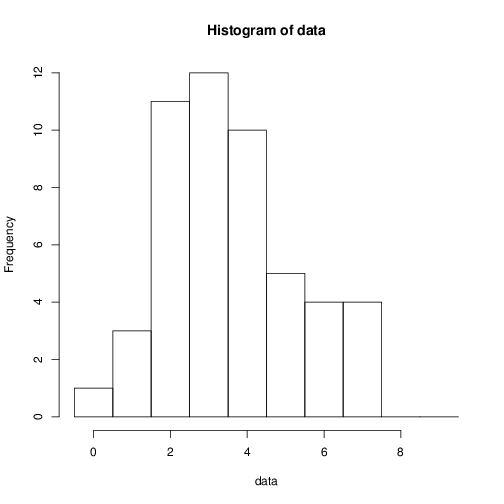

In [5]:
# Rのhistを使ってヒストグラムをプロットする
graph = preGraph("images/ch2_fig2.2-R.pdf")
r('p <- hist(data, breaks = seq(-0.5, 9.5, 1))')
postGraph(graph)

<html>
	<h2>Pandasを使って同様の処理に挑戦</h2>
	<p>
		Rのライブラリはとても豊富で実績もありますが、個人的には関数の定義が分かりずらいのであまり好きではありません。
	</p>
	<p>
		そこで、SageにPandasライブラリをインストールして、これを使って同じような処理をしてみました。
	</p>
	<p>
		Rから配列データを取り出すには、sageobj関数を使います。
	</p>
</html>

In [6]:
# 同様の処理をPandasを使ってやってみます
# rからSageにデータを変換
data = sageobj(r('data'))

<html>
	<h3>データフレームに変換</h3>
	<p>
		Rから取り込んだ2章のデータをPandasのデータフレームにします。
	</p>
</html>

In [7]:
# ggplotでプロットできるようにDataFrameにする
orgData = pd.DataFrame(data, columns = ['data'])

<html>
	<p>
		データフレームにしたorgDataからRのsummaryと同様の情報をdescribeを使って得ることができます。
	</p>
</html>

In [8]:
# RのsummaryのようにPandasのDataFrameの情報を出力するには、describeを使います
orgData.describe()

,data
count,50.00000
mean,3.56000
std,1.72804
min,0.00000
25%,2.00000
50%,3.00000
75%,4.75000
max,7.00000


<html>
	<h3>Sageのヒストグラムを表示</h3>
	<p>
		ようやくSageにもhistogram関数が用意されたので、これを使ってみます。
	</p>
</html>

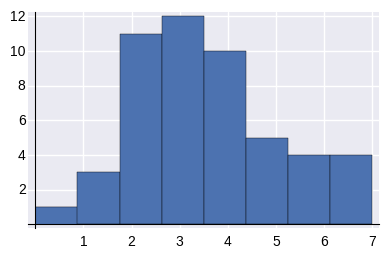

In [9]:
hist_plt = histogram(orgData.data, bins= 8, figsize=4)
hist_plt.show()

<html>
	<h2>ポアソン分布の表示</h2>
	<p>
		データのsummaryで平均値と分散が同じ値を示すことからデータ分布をポアソン分布と推定しています。
	</p>
	<p>
		ポアソン分布では、データの平均がポアソン分布のλの値になることから、データの平均3.56のポアソン分布
		を表示してみます。
	</p>
	<p>
		yに０から9の値をセットし、r.dpoisでSageからRのdpoisを使って、Yに対するポアソン密度を計算し、その値（n()）を浮動小数に変換して
		probにセットします。
	</p>
</html>

In [10]:
y = range(10); y

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [11]:
# dpoisの戻り値が複素数になっているので、floatで浮動小数に変換し、50個の場合の確率にする
prob = [50*float(sageobj(r.dpois(v, 3.56))) for v in y]; prob

[1.4219412357092251,
 5.0621107991248495,
 9.0105572224422,
 10.69252790396475,
 9.51634983452865,
 6.7756410821844,
 4.02021370876274,
 2.0445658290279103,
 0.90983179391742,
 0.35988902070511203]

<html>
	<h3>ポアソン分布をプロットする</h3>
	<p>
		Sageのlist_plotを使ってλ=3.56に対するポアソン分布をプロットします。
	</p>
</html>

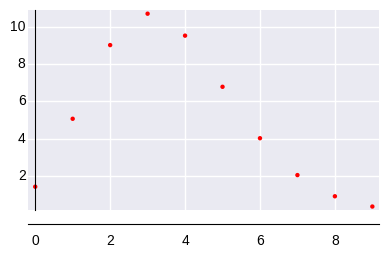

In [12]:
# Sage版 Fig. 2.4
list_plt = list_plot(zip(y, prob), rgbcolor='red', zorder=2, figsize=4)
list_plt.show()

<html>
<p>
sageのグラフの重ね合わせ機能を使って、 ヒストグラムとポアソン分布を重ねて表示してみます。
デフォルのままだとlist_plotの結果がヒストグラムに隠れてしまいます。
</p>
<p>
そこで、list_plotの引数にzorderで表示順序を指定（大きい方が前面に表示されます）します。
</p>
</html>

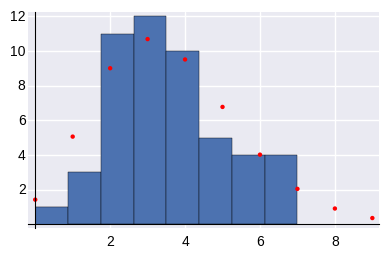

In [13]:
(hist_plt+list_plt).show()

<html>
<p>
同様の処理をpandasのplot機能で試してみました。pandasではx軸の情報がplot関数の戻り値に返されるので、
これを重ねるplotのaxにセットすることで、図の重ね合わせができるようになります。
</p>
</html>

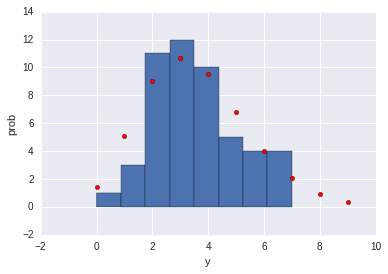

In [14]:
# yとprobからデータフレームを作る
# pandasのplot機能を使用
df = pd.DataFrame(zip(y, prob), columns = ['y', 'prob'])
ax = orgData.data.hist(bins=8)
scatter = df.plot(kind='scatter', x='y', y='prob', color='red', zorder=2, ax=ax)

<html>
	<h2>ポアソン分布の特徴</h2>
	<p>
		ポアソン分布がλを変えることでどのように分布が変わるのか、見てみましょう。
		SageのGraphisもグラフの重ね合わせたggplot同様にともて簡単です。
	</p>
	<p>
		ですから、ggplotとSageの相性もとても良いのです。
	</p>
</html>

In [15]:
# ポアソン関数p(y, λ)を定義
def p(y, lam):
    return lam^y*e^(-lam)/factorial(y)

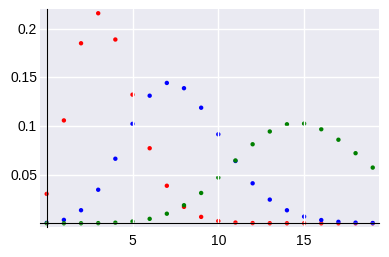

In [16]:
# 様々な平均（λ）のポアソン分布
# Fig. 2.6
g = Graphics()
for lam, cls in [(3.5, 'red'), (7.7, 'blue'), (15.1, 'green')]:
    g = g + list_plot([p(y, lam) for y in range(20)], color=cls, figsize=4)
g.show()

<html>
	<h2>ポアソン分布の最尤推定</h2>
	<p>
		尤度を「あてはまりの良さ」であり、L(λ)と書きます。ポアソン分布の尤度は、以下の式で与えられます。
$$
	L(\lambda) = \prod_{i} p(y_i | \lambda) = \prod_{i} \frac{\lambda^{y_i} exp(-\lambda)}{y_i !}
$$
	</p>
	<p>
		L(λ) の対数とったものを対数尤度と呼び、上記の定義から以下のように表されます。
$$
	log L(\lambda) =  \sum_{i} \left( y_i log \lambda - \lambda - \sum_{k}^{y_i} log k \right)
$$
	</p>
	<p>
		このL(λ)が最大になるλは、L(λ)をλで偏微分することで求まります。
$$
		\frac{\partial log L(\lambda)}{\partial \lambda} = \sum_i \left\{ \frac{y_i}{\lambda} - 1 \right \} = \frac{1}{\lambda} \sum_i y_i - k = 0
$$		
		この結果は、データの標本平均$\hat{\lambda}$となり、例題のデータに当てはめると以下の様になります。
$$
		\hat{\lambda} = \frac{1}{50} \sum_i y_i = データの標本平均 = 3.56
$$
	</p>
	<p>
		この式を例題のデータに対して、λ = 3.6としてその値の和をとると、図2.7のlogL = -97.3の値を得ます。
	</p>
</html>

In [17]:
# lambda=3.6の対数尤度を計算してみる。本の図2.7のlog Lと同じ値であることを確認
orgData.data.apply(lambda y : r.dpois(y, 3.6, log=True)).sum()

[1] -97.25516

<html>
	<h3>例題データの対数尤度を計算する関数logLを定義</h3>
	<p>
		そこで、例題データに対する対数尤度を計算するlogLを以下のように定義し、
		対数尤度が最大になるようなλを求めてみます。
	</p>
</html>

In [18]:
# 対数尤度の計算
def logL(m):
    return sageobj(orgData.data.apply(lambda y : r.dpois(y, m, log=True)).sum())

<html>
	<p>
		確認のため、 今度は$\lambda=2.0$の対数尤度は、logL = -121.9と一致します。
	</p>
</html>

In [19]:
# 関数の確認、今度はlambda=2の値でチェック
print logL(2)

-121.881181787


<html>
	<h3>例題の最尤推定値</h3>
	<p>
		λの最尤推定値をグラフから求めてみます。λ=2.0から5.0を0.1刻みで計算してみます。
	</p>
</html>

In [20]:
# グラフから最大となる対数尤度を求める（少し時間が掛かる）
lams = np.arange(2.0, 5.0, 0.1)
Ls = [logL(x) for x in lams]

<html>
	<p>
		結果は、以下の様になり、標本の平均値3.56近辺で最大になっていることがわかります。
	</p>
</html>

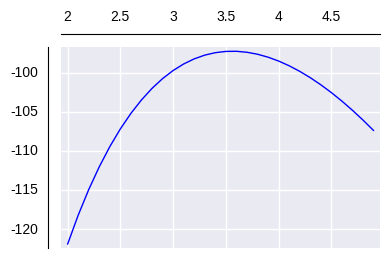

In [21]:
# plotだと時間がかかるので、list_plotで代用
# Fig. 2.8
list_plot(zip(lams, Ls), figsize=4, plotjoined =True)

<html>
	<h2>疑似乱数と最尤推定値のばらつき</h2>
	<p>
		久保本のすごいところは、疑似乱数を使って最尤推定値のばらつきまでみているところです。
	</p>
	<p>
		平均3.5のポアソン分布の50個のサンプルを1000セット作って、そのヒストグラムをプロット
		してみます。
	</p>
</html>

In [22]:
# 平均3.5のポアソン分布のサンプルを50個を1000セット生成して、最尤推定値のばらつきを見る
poisSet3000 = [ sageobj(r.rpois(50, 3.5).mean()) for i in range(1000)]

<html>
	<h3>最尤推定値のばらつき</h3>
	<p>
		今度は、Pandasの持つ、ヒストグラムプロット機能を使って最尤推定値のばらつきをプロットしてみます。
	</p>
</html>

In [23]:
# Pandasのグラフ機能を使ってヒストグラムを表示する
df3000 = pd.DataFrame({ 'lambda': np.array(poisSet3000)}); df3000.head()

,lambda
0,3.82
1,3.68
2,3.20
3,3.52
4,3.60


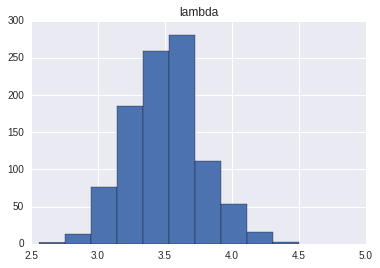

In [24]:
df3000.hist()
plt.savefig("images/df3000.png", dpi=70)

## 確率分布の選び方
離散値の場合
- ポアソン分布：ゼロ以上の範囲、上限なし、平均 $\approx$ 分散
- 二項分布：ゼロ以上で有限の範囲内、分散は平均の関数

連続値の場合
- 正規分布: 範囲が$[ -\infty, +\infty]$、分散は平均とは無関係に決まる
- ガンマ分布：範囲が$[0, +\infty]$、分散は平均の関数